<a href="https://colab.research.google.com/github/rangakamesh/Bulletin-Board-Server/blob/master/2D_Barcode_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connect to G-Drive


In [14]:
#install required packages for the application
!pip install opencv-python
!pip install ripser

#import required packages
import cv2
import numpy as np
from skimage import io, restoration, util
from google.colab import drive
import matplotlib.pyplot as plt

#connect to G-Drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/Colab Notebooks/SIEMENS"
import TDAimgprocess as TIP # topological image modification and processing
import time

%cd "/content/drive/MyDrive/Colab Notebooks/SIEMENS/barcodes"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/SIEMENS
/content/drive/MyDrive/Colab Notebooks/SIEMENS/barcodes


#Read the images, make it grayscale and apply binary threshold.

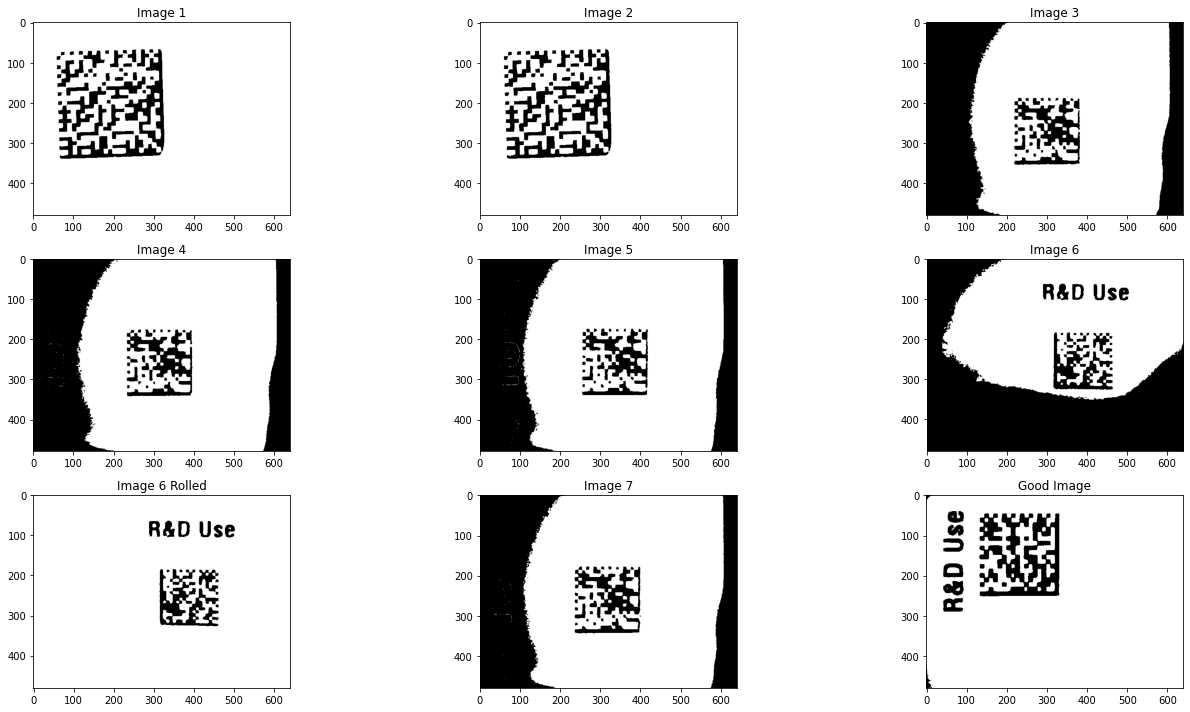

In [15]:
#read all input images, process and store them in memory

def applyRollingBall(tempImage):

  if (type(tempImage[0,0]) != np.uint8):
    tempImage = cv2.cvtColor(tempImage,cv2.COLOR_BGR2GRAY)

  tempImageInverted = util.invert(tempImage)

  ballRadius = 50.0
  normalized_radius = ballRadius / 255
  kernel = restoration.ellipsoid_kernel((ballRadius * 2, ballRadius * 2), normalized_radius * 2 )

  backgroundInverted = restoration.rolling_ball(tempImageInverted, kernel=kernel)
  filteredInvertedTempImage = tempImageInverted - backgroundInverted

  tempImage = util.invert(filteredInvertedTempImage)

  return tempImage

def readAndReturnBinaryImage(fileName):
  tempImage = cv2.imread(fileName, 0)
  # tempImage = applyRollingBall(tempImage)
  ret, tempImage = cv2.threshold(tempImage, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return tempImage

orig_image1 = cv2.imread("BC_14_200116_110356_2700_G.bmp",0)
orig_image2 = cv2.imread("BC_14_200116_110416_2700_G.bmp",0)
orig_image3 = cv2.imread("BC_6_210416_163141_2700_G.bmp",0)
orig_image4 = cv2.imread("BC_6_210416_165639_2700_G.bmp",0)
orig_image5 = cv2.imread("BC_6_210416_170047_2700_G.bmp",0)
orig_image6 = cv2.imread("qrcode.jpg",0)
orig_image6_rolled = cv2.imread("qrcodeOutputBGSubtracted.jpg",0)
orig_image7 = cv2.imread("inputMatrix.bmp",0)
orig_good_image = cv2.imread("Good.bmp",0)


image1 = readAndReturnBinaryImage("BC_14_200116_110356_2700_G.bmp")
image2 = readAndReturnBinaryImage("BC_14_200116_110416_2700_G.bmp")
image3 = readAndReturnBinaryImage("BC_6_210416_163141_2700_G.bmp")
image4 = readAndReturnBinaryImage("BC_6_210416_165639_2700_G.bmp")
image5 = readAndReturnBinaryImage("BC_6_210416_170047_2700_G.bmp")
image6 = readAndReturnBinaryImage("qrcode.jpg")
image6_rolled = readAndReturnBinaryImage("qrcodeOutputBGSubtracted.jpg")
image7 = readAndReturnBinaryImage("inputMatrix.bmp")
good_image = readAndReturnBinaryImage("Good.bmp")


# use numpy to create an array of color
image_height = 480
image_width = 640
number_of_color_channels = 3
color = (255,255,255)
pixel_array = np.full((image_height, image_width, number_of_color_channels), color, dtype=np.uint8)

fig, axes = plt.subplots(3, 3, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(image1, cmap=plt.cm.gray)
ax[0].set_title("Image 1")
ax[1].imshow(image2, cmap=plt.cm.gray)
ax[1].set_title("Image 2")
ax[2].imshow(image3, cmap=plt.cm.gray)
ax[2].set_title("Image 3")
ax[3].imshow(image4, cmap=plt.cm.gray)
ax[3].set_title("Image 4")
ax[4].imshow(image5, cmap=plt.cm.gray)
ax[4].set_title("Image 5")
ax[5].imshow(image6, cmap=plt.cm.gray)
ax[5].set_title("Image 6")
ax[6].imshow(image6_rolled, cmap=plt.cm.gray)
ax[6].set_title("Image 6 Rolled")
ax[7].imshow(image7, cmap=plt.cm.gray)
ax[7].set_title("Image 7")
ax[8].imshow(good_image, cmap=plt.cm.gray)
ax[8].set_title("Good Image")


fig.tight_layout()
plt.show()

#Method 1 : Edge detection

##Preprocess, Morph and detect contour.

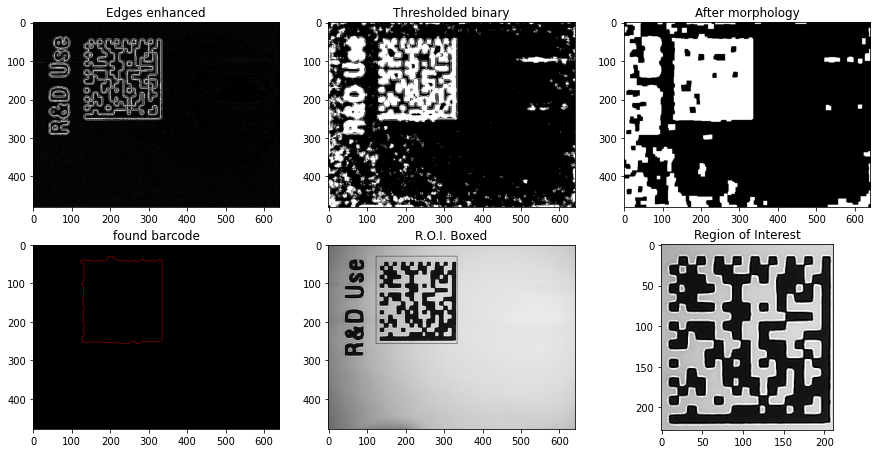

In [18]:
image = cv2.imread("Good.bmp")
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))
ax = axes.ravel()

# equalize lighting
gray = util.invert(gray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray = clahe.apply(gray)
gray = util.invert(gray)


# edge enhancement
edge_enh = cv2.Laplacian(gray, ddepth = cv2.CV_8U, ksize = 3, scale = 1, delta = 0)

ax[0].imshow(edge_enh, cmap=plt.cm.gray)
ax[0].set_title("Edges enhanced")

# bilateral blur, which keeps edges
blurred = cv2.bilateralFilter(edge_enh, 13, 50, 50)

# use simple thresholding. adaptive thresholding might be more robust
(_, thresh) = cv2.threshold(blurred, 5, 255, cv2.THRESH_BINARY)
ax[1].imshow(thresh, cmap=plt.cm.gray)
ax[1].set_title("Thresholded binary")

# do some morphology to isolate just the barcode blob
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
closed = cv2.erode(closed, None, iterations = 4)
closed = cv2.dilate(closed, None, iterations = 4)
ax[2].imshow(closed, cmap=plt.cm.gray)
ax[2].set_title("After morphology")

# find contours left in the image
cnts, hei = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
imageCopy = image.copy() #taking a copy to draw the contour box
areas = map(lambda x: cv2.contourArea(cv2.convexHull(x)), cnts)  
areas = list(areas)  
max_i = areas.index(max(areas))
d = cv2.drawContours(np.zeros_like(imageCopy), cnts, max_i, 255, 1)
ax[3].imshow(d, cmap=plt.cm.gray)
retJunk = ax[3].set_title("found barcode")

#Draw a border around the region of interest with the contour
rect =cv2.minAreaRect(cnts[max_i])
box = cv2.boxPoints(rect)
box = np.int0(box)
e= cv2.drawContours(imageCopy,[box],0,1,1)
ax[4].imshow(e, cmap=plt.cm.gray)
retJunk = ax[4].set_title("R.O.I. Boxed")

#Extract the region of interest
x,y,w,h = cv2.boundingRect(cnts[max_i])
ROI = image[y:y+h, x:x+w]
ax[5].imshow(ROI, cmap=plt.cm.gray)
retJunk = ax[5].set_title("Region of Interest")

##Applying to all the images

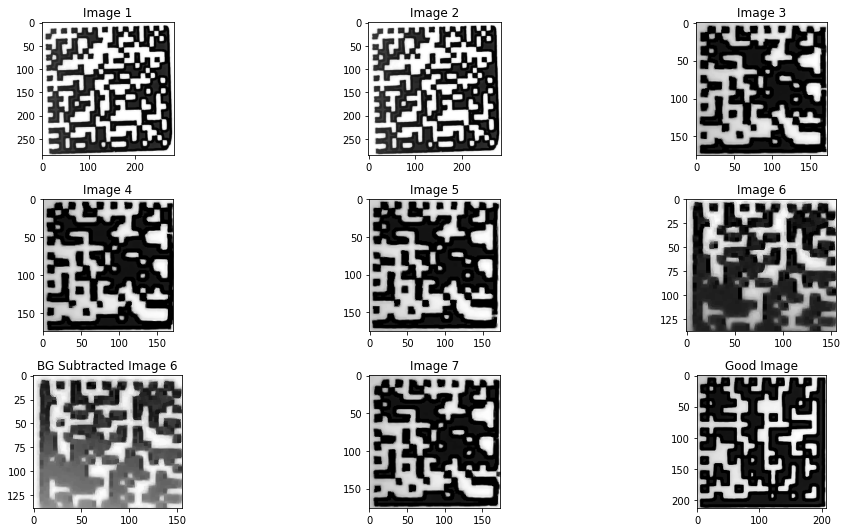

In [27]:
def setContourBoundary(inputImage):

  # if (inputImage[0,0]!=np.uint8):
  #   inputImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)

  inputImage = util.invert(inputImage)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  gray = clahe.apply(inputImage.copy())
  inputImage = util.invert(inputImage)

  edge_enh = cv2.Laplacian(gray, ddepth = cv2.CV_8U, ksize = 1, scale = 1, delta = 0)

  blurred = cv2.bilateralFilter(edge_enh, 13, 50, 50)


  (_, thresh) = cv2.threshold(blurred, 5, 255, cv2.THRESH_BINARY)


  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
  closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
  # closed = cv2.erode(closed, None, iterations = 4)
  # closed = cv2.dilate(closed, None, iterations = 4)

  cnts, hei = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
  rect = cv2.minAreaRect(c)
  box = np.int0(cv2.boxPoints(rect))
  
  # e= cv2.drawContours(inputImage,[box],-1, (0, 255, 0), 3)

  x,y,w,h = cv2.boundingRect(box)
  ROI = inputImage[y:y+h, x:x+w]

  dilateKernel = np.ones((2,2), np.uint8)
  ROI = cv2.erode(ROI, dilateKernel, iterations = 4)
  ROI = cv2.dilate(ROI, dilateKernel, iterations = 1)

  return ROI


contoured_image1 = setContourBoundary(orig_image1.copy())
contoured_image2 = setContourBoundary(orig_image2.copy())
contoured_image3 = setContourBoundary(orig_image3.copy())
contoured_image4 = setContourBoundary(orig_image4.copy())
contoured_image5 = setContourBoundary(orig_image5.copy())
contoured_image6 = setContourBoundary(orig_image6.copy())
contoured_image6_bgsub = setContourBoundary(orig_image6_rolled.copy())
contoured_image7 = setContourBoundary(orig_image7.copy())
contoured_good_image = setContourBoundary(orig_good_image.copy())

fig, axes = plt.subplots(3, 3, figsize=(15, 7.5))
ax = axes.ravel()

ax[0].imshow(contoured_image1, cmap=plt.cm.gray)
ax[0].set_title("Image 1")
ax[1].imshow(contoured_image2, cmap=plt.cm.gray)
ax[1].set_title("Image 2")
ax[2].imshow(contoured_image3, cmap=plt.cm.gray)
ax[2].set_title("Image 3")
ax[3].imshow(contoured_image4, cmap=plt.cm.gray)
ax[3].set_title("Image 4")
ax[4].imshow(contoured_image5, cmap=plt.cm.gray)
ax[4].set_title("Image 5")
ax[5].imshow(contoured_image6, cmap=plt.cm.gray)
ax[5].set_title("Image 6")
ax[6].imshow(contoured_image6_bgsub, cmap=plt.cm.gray)
ax[6].set_title("BG Subtracted Image 6")
ax[7].imshow(contoured_image7, cmap=plt.cm.gray)
ax[7].set_title("Image 7")
ax[8].imshow(contoured_good_image, cmap=plt.cm.gray)
ax[8].set_title("Good Image")

fig.tight_layout()
plt.show()

#Method 2 : Corner detection

##Harris Corner Detection
https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html

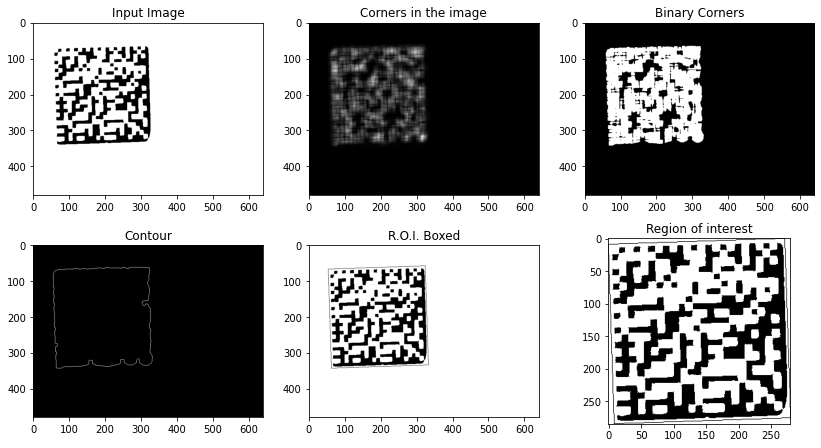

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7.5))
ax = axes.ravel()

testImage = image2.copy()
ax[0].imshow(testImage, cmap=plt.cm.gray)
ax[0].set_title("Input Image")

harris = cv2.cornerHarris(testImage, 20, 1, 0)
ax[1].imshow(harris, cmap=plt.cm.gray)
ax[1].set_title("Corners in the image")

x, thr = cv2.threshold(harris, 0.1 * harris.max(), 255, cv2.THRESH_BINARY)
thr = thr.astype('uint8')
ax[2].imshow(thr, cmap=plt.cm.gray)
ax[2].set_title("Binary Corners")

thr = cv2.dilate(thr, None, iterations = 3)
thr = cv2.erode(thr, None, iterations = 1)

contours, hierarchy = cv2.findContours(thr.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
areas = map(lambda x: cv2.contourArea(cv2.convexHull(x)), contours)  
areas = list(areas)  
max_i = areas.index(max(areas))
d = cv2.drawContours(np.zeros_like(thr), contours, max_i, 255, 1)
ax[3].imshow(d, cmap=plt.cm.gray)
ax[3].set_title("Contour")

rect =cv2.minAreaRect(contours[max_i])
box = cv2.boxPoints(rect)
box = np.int0(box)
e= cv2.drawContours(testImage,[box],0,1,1)
ax[4].imshow(e, cmap=plt.cm.gray)
retJunk = ax[4].set_title("R.O.I. Boxed")

x,y,w,h = cv2.boundingRect(box)
ROI = testImage[y:y+h, x:x+w]
ax[5].imshow(ROI, cmap=plt.cm.gray)
retJunk = ax[5].set_title("Region of interest")

##Applying to all the images

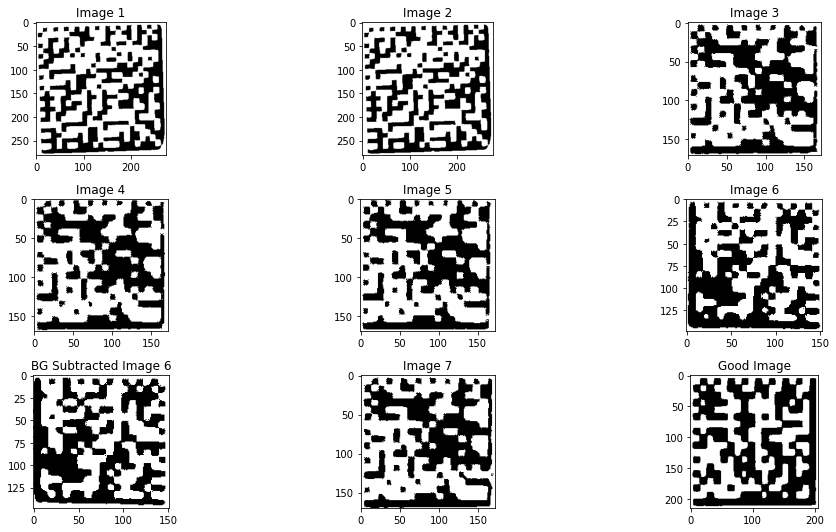

In [33]:
def setContourBoundaryByCorners(inputImage):
  harris = cv2.cornerHarris(inputImage, 20, 1, 0)

  x, thr = cv2.threshold(harris, 0.1 * harris.max(), 255, cv2.THRESH_BINARY)
  thr = thr.astype('uint8')
  
  contours, hierarchy = cv2.findContours(thr.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
  areas = map(lambda x: cv2.contourArea(cv2.convexHull(x)), contours)  
  areas = list(areas)  
  max_i = areas.index(max(areas))
  # d = cv2.drawContours(np.zeros_like(thr), contours, max_i, 255, 1)

  rect =cv2.minAreaRect(contours[max_i])
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  # e= cv2.drawContours(inputImage,[box],0,1,1)

  x,y,w,h = cv2.boundingRect(box)
  ROI = inputImage[y:y+h, x:x+w]

  # Dilate and Erode to fill gaps
  # dilateKernel = np.ones((2,2), np.uint8)
  # ROI = cv2.erode(ROI, dilateKernel, iterations = 4)
  # ROI = cv2.dilate(ROI, dilateKernel, iterations = 1)

  return ROI

corner_extracted_image1 = setContourBoundaryByCorners(image1.copy())
corner_extracted_image2 = setContourBoundaryByCorners(image2.copy())
corner_extracted_image3 = setContourBoundaryByCorners(image3.copy())
corner_extracted_image4 = setContourBoundaryByCorners(image4.copy())
corner_extracted_image5 = setContourBoundaryByCorners(image5.copy())
corner_extracted_image6 = setContourBoundaryByCorners(image6.copy())
corner_extracted_image6_bgsub = setContourBoundaryByCorners(image6_rolled.copy())
corner_extracted_image7 = setContourBoundaryByCorners(image7.copy())
corner_extracted_good_image = setContourBoundaryByCorners(good_image.copy())

fig, axes = plt.subplots(3, 3, figsize=(15, 7.5))
ax = axes.ravel()

ax[0].imshow(corner_extracted_image1, cmap=plt.cm.gray)
ax[0].set_title("Image 1")
ax[1].imshow(corner_extracted_image2, cmap=plt.cm.gray)
ax[1].set_title("Image 2")
ax[2].imshow(corner_extracted_image3, cmap=plt.cm.gray)
ax[2].set_title("Image 3")
ax[3].imshow(corner_extracted_image4, cmap=plt.cm.gray)
ax[3].set_title("Image 4")
ax[4].imshow(corner_extracted_image5, cmap=plt.cm.gray)
ax[4].set_title("Image 5")
ax[5].imshow(corner_extracted_image6, cmap=plt.cm.gray)
ax[5].set_title("Image 6")
ax[6].imshow(corner_extracted_image6_bgsub, cmap=plt.cm.gray)
ax[6].set_title("BG Subtracted Image 6")
ax[7].imshow(corner_extracted_image7, cmap=plt.cm.gray)
ax[7].set_title("Image 7")
ax[8].imshow(corner_extracted_good_image, cmap=plt.cm.gray)
ax[8].set_title("Good Image")

fig.tight_layout()
plt.show()

#Method 3 : Topological processing

##Extract barcode location mask using TIP

Time for Topological Image Processing: 00:00:01


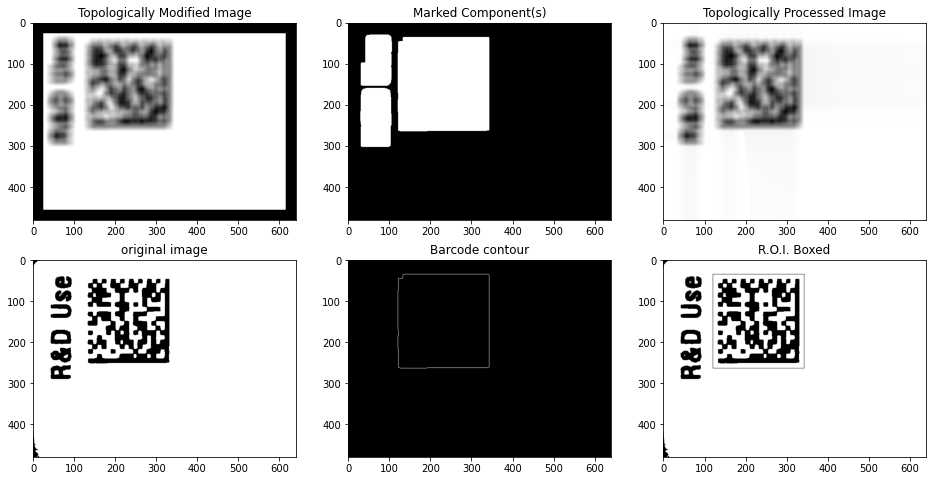

In [20]:
tpImage = good_image.copy()

np.random.seed(42)

img_gray = tpImage.astype("float") # grayscale
img_gray += 0.01 * np.random.randn(*img_gray.shape) # random noise

window_size = 25
border_width = 25

start_time = time.time()
TIP_img = TIP.topological_process_img(img_gray, window_size=window_size, border_width=border_width)
elapsed_time = time.time() - start_time
print("Time for Topological Image Processing: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
ax = axes.flatten()

ax[0].imshow(TIP_img["modified"], cmap="gray")
# ax[0].set_axis_off()
ax[0].set_title("Topologically Modified Image", fontsize=12)

TIPed_components = TIP_img["components"].astype("uint8")
ax[1].imshow(TIPed_components, cmap="gray")
# ax[1].set_axis_off()
ax[1].set_title("Marked Component(s)", fontsize=12)

ax[2].imshow(TIP_img["processed"], cmap="gray")
# ax[2].set_axis_off()
ax[2].set_title("Topologically Processed Image", fontsize=12)

imageCopy = good_image.copy() #taking a copy to draw the contour box
ax[3].imshow(imageCopy, cmap=plt.cm.gray)
ax[3].set_title("original image")

cnts, hei = cv2.findContours(TIPed_components.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas = map(lambda x: cv2.contourArea(cv2.convexHull(x)), cnts)  
areas = list(areas)  
max_i = areas.index(max(areas))
d = cv2.drawContours(np.zeros_like(imageCopy), cnts, max_i, 255, 1)
ax[4].imshow(d, cmap=plt.cm.gray)
ax[4].set_title("Barcode contour")

#Draw a border around the region of interest with the contour
rect =cv2.minAreaRect(cnts[max_i])
box = cv2.boxPoints(rect)
box = np.int0(box)
e= cv2.drawContours(imageCopy,[box],0,1,1)
ax[5].imshow(e, cmap=plt.cm.gray)
retJunk = ax[5].set_title("R.O.I. Boxed")


##Apply TIP to all the images

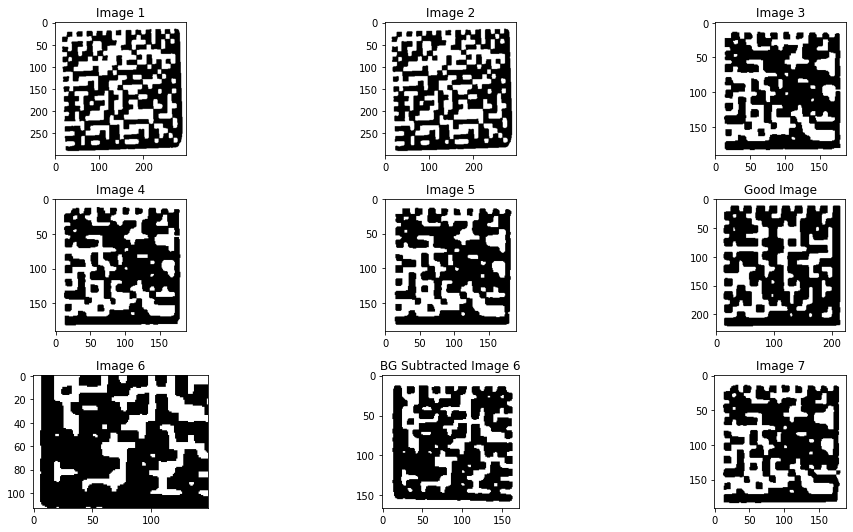

In [25]:
def tipExtraction(inputImage):
  np.random.seed(42)

  img_gray = inputImage.astype("float") # grayscale
  img_gray += 0.01 * np.random.randn(*img_gray.shape) # random noise

  window_size = 25
  border_width = 25

  TIP_img = TIP.topological_process_img(img_gray, window_size=window_size, border_width=border_width)
  TIPed_components = TIP_img["components"].astype("uint8")

  imageCopy = inputImage.copy() #taking a copy to draw the contour box

  cnts, hei = cv2.findContours(TIPed_components.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  areas = map(lambda x: cv2.contourArea(cv2.convexHull(x)), cnts)  
  areas = list(areas)  
  max_i = areas.index(max(areas))
  # d = cv2.drawContours(np.zeros_like(imageCopy), cnts, max_i, 255, 1)

  rect =cv2.minAreaRect(cnts[max_i])
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  e= cv2.drawContours(imageCopy,[box],0,1,1)

  x,y,w,h = cv2.boundingRect(box)
  ROI = inputImage[y:y+h, x:x+w]

  dilateKernel = np.ones((2,2), np.uint8)
  ROI = cv2.erode(ROI, dilateKernel, iterations = 4)
  ROI = cv2.dilate(ROI, dilateKernel, iterations = 1)

  return ROI

tipped_image1 = tipExtraction(image1.copy())
tipped_image2 = tipExtraction(image2.copy())
tipped_image3 = tipExtraction(image3.copy())
tipped_image4 = tipExtraction(image4.copy())
tipped_image5 = tipExtraction(image5.copy())
tipped_image6 = tipExtraction(image6.copy())
tipped_image6_bgsub = tipExtraction(image6_rolled.copy())
tipped_image7 = tipExtraction(image7.copy())
tipped_good_image = tipExtraction(good_image.copy())

fig, axes = plt.subplots(3, 3, figsize=(15, 7.5))
ax = axes.ravel()

ax[0].imshow(tipped_image1, cmap=plt.cm.gray)
ax[0].set_title("Image 1")
ax[1].imshow(tipped_image2, cmap=plt.cm.gray)
ax[1].set_title("Image 2")
ax[2].imshow(tipped_image3, cmap=plt.cm.gray)
ax[2].set_title("Image 3")
ax[3].imshow(tipped_image4, cmap=plt.cm.gray)
ax[3].set_title("Image 4")
ax[4].imshow(tipped_image5, cmap=plt.cm.gray)
ax[4].set_title("Image 5")
ax[5].imshow(tipped_good_image, cmap=plt.cm.gray)
ax[5].set_title("Good Image")
ax[6].imshow(tipped_image6, cmap=plt.cm.gray)
ax[6].set_title("Image 6")
ax[7].imshow(tipped_image6_bgsub, cmap=plt.cm.gray)
ax[7].set_title("BG Subtracted Image 6")
ax[8].imshow(tipped_image7, cmap=plt.cm.gray)
ax[8].set_title("Image 7")


fig.tight_layout()
plt.show()

#Decoder

In [84]:
!apt-get install libdmtx0a
!pip install pylibdmtx

from pylibdmtx.pylibdmtx import decode

decodedMsg = decode(corner_extracted_good_image)
print(decodedMsg)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libdmtx0a is already the newest version (0.7.4-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
[Decoded(data=b'00 500695 16-19284-20', rect=Rect(left=202, top=4, width=-197, height=204))]


#Write to drive

In [128]:
%cd sourceLocation+barcodeFolder

cv2.imwrite(sourceLocation+"/cornerExtraction/image1.jpg",corner_extracted_image1)
cv2.imwrite(sourceLocation+"/cornerExtraction/image2.jpg",corner_extracted_image2)
cv2.imwrite(sourceLocation+"/cornerExtraction/image3.jpg",corner_extracted_image3)
cv2.imwrite(sourceLocation+"/cornerExtraction/image4.jpg",corner_extracted_image4)
cv2.imwrite(sourceLocation+"/cornerExtraction/image5.jpg",corner_extracted_image5)
cv2.imwrite(sourceLocation+"/cornerExtraction/good_image.jpg",corner_extracted_good_image)

cv2.imwrite(sourceLocation+"/edgeExtraction/image1.jpg",contoured_image1)
cv2.imwrite(sourceLocation+"/edgeExtraction/image2.jpg",contoured_image2)
cv2.imwrite(sourceLocation+"/edgeExtraction/image3.jpg",contoured_image3)
cv2.imwrite(sourceLocation+"/edgeExtraction/image4.jpg",contoured_image4)
cv2.imwrite(sourceLocation+"/edgeExtraction/image5.jpg",contoured_image5)
cv2.imwrite(sourceLocation+"/edgeExtraction/image6.jpg",contoured_image6)
cv2.imwrite(sourceLocation+"/edgeExtraction/image7.jpg",contoured_image7)
cv2.imwrite(sourceLocation+"/edgeExtraction/good_image.jpg",contoured_good_image)

[Errno 2] No such file or directory: 'sourceLocation+barcodeFolder'
/content/drive/MyDrive/Colab Notebooks/SIEMENS/barcodes


False